# HW-2 - Regression

The goal of this homework is to create a regression model for predicting housing prices (column `median_house_value`).

## 1. Import the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## 2. Import dataset

In [2]:
dff = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [3]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
dff.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## 3. EDA
- Look at the median_house_value variable. Does it have a long tail?

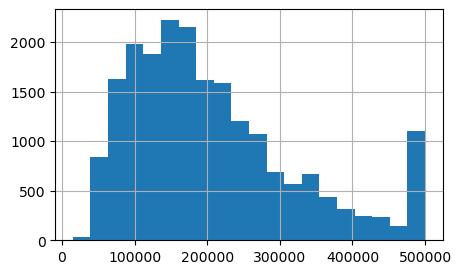

In [5]:
plt.figure(figsize=(5,3))
dff["median_house_value"].hist(bins=20);

### Preparing the dataset
- First, keep only the records where `ocean_proximity` is either `<1H OCEAN` or `INLAND`

In [6]:
dff["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
# Create the filter for 'ocean_proximity'
mask = (dff["ocean_proximity"] == "<1H OCEAN") + (dff["ocean_proximity"] == "INLAND")
len(dff[mask]) # Validate number of rows for the filter

15687

In [8]:
# Apply the filter for 'ocean_proximity' in a new dataset df_filter
df_filter = dff[mask]
df_filter.info() # Validate structure of the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


- Next, use only the following columns:

`['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']`

In [9]:
df = df_filter[mask][[
    "latitude",
    "longitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value"]]
print(df.shape)
df.head()

(15687, 9)


C:\Users\Anderson\AppData\Local\Temp\ipykernel_9860\1984840822.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_filter[mask][[


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


## Question 1

There's one feature with missing values. What is it? = `total_bedrooms`

In [10]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Question 2
What's the median (50% percentile) for variable `population`? = `1195`


In [11]:
df["population"].describe()

count    15687.000000
mean      1466.317205
std       1180.389908
min          3.000000
25%        802.000000
50%       1195.000000
75%       1777.000000
max      35682.000000
Name: population, dtype: float64

### Prepare and split the dataset

- Shuffle the dataset (the filtered one you created above), use seed 42.    

In [12]:
# Dataset before shuffle
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


In [13]:
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_s = df.iloc[idx]
df_s.head() # Dataset after shuffle

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
19963,36.23,-119.14,22.0,2935.0,523.0,1927.0,530.0,2.5875,70400.0
5929,34.12,-117.79,16.0,2426.0,426.0,1319.0,446.0,4.8125,224500.0
11377,33.68,-117.97,26.0,3653.0,568.0,1930.0,585.0,5.7301,260900.0
6443,34.10,-118.03,32.0,2668.0,609.0,1512.0,541.0,2.9422,233100.0
17546,37.34,-121.87,39.0,2479.0,541.0,1990.0,506.0,2.4306,289100.0


- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [14]:
# Define the lenght of the train/validation/test subsets
n = len(df_s)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
print(f'(n: {n}),(n_train: {n_train}), (n_val: {n_val}), (n_test: {n_test})')

(n: 15687),(n_train: 9413), (n_val: 3137), (n_test: 3137)


In [15]:
# Another way of splitting the data
target = ["median_house_value"] # Define the target column

# Define the 'X' & 'y' dataframes for the regression
X = df_s.drop(labels=target, axis=1)
y = df_s[target]

# Define the size of split subsets, before using train_test_split function
len_test = 0.2
len_val = 0.2/(1 - len_test)
print(f'X: {X.shape}, y: {y.shape}, test_size: {len_test}, val_size: {len_val}')

X: (15687, 8), y: (15687, 1), test_size: 0.2, val_size: 0.25


In [16]:
# Use the train_test_split function of scikit-learn to split dataframes 'X' & 'y'
X_0, X_test, y_0, y_test_lin = train_test_split(X, y, test_size=len_test, random_state=42, shuffle=False) 

# X_0 & y_0 are then splitted into train/val subsets
X_train, X_val, y_train_lin, y_val_lin = train_test_split(X_0, y_0, test_size=len_val, random_state=42, shuffle=False)

print(f'X_train:{X_train.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}')

X_train:(9411, 8), X_val:(3138, 8), X_test:(3138, 8)


In [17]:
# Reset the index of the train/validation/test subsets
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

- Apply the log transformation to the `median_house_value` variable using the `np.log1p()` function.

In [18]:
y_train = np.log1p(y_train_lin)
y_val = np.log1p(y_val_lin)
y_test = np.log1p(y_test_lin)

## Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with `0` or with the `mean` of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Which option gives better RMSE? = `Both are equally good`

In [19]:
# Verify NaNs in 'total_bedrooms' column
X_train.isna().sum()

latitude               0
longitude              0
housing_median_age     0
total_rooms            0
total_bedrooms        94
population             0
households             0
median_income          0
dtype: int64

In [20]:
# Calculate the 'total_bedrooms' column mean
mean_tot_bed_train = X_train["total_bedrooms"].mean()
mean_tot_bed_train

542.5265643447461

In [21]:
# Fill the NaNs values with '0'
X_train_0 = X_train.copy()
X_val_0 = X_val.copy()
X_test_0 = X_test.copy()
X_train_0["total_bedrooms"].fillna(value=0, inplace=True)
X_val_0["total_bedrooms"].fillna(value=0, inplace=True)
X_test_0["total_bedrooms"].fillna(value=0, inplace=True)

In [22]:
# Fill the NaNs values with 'mean'
X_train_m = X_train.copy()
X_val_m = X_val.copy()
X_test_m = X_test.copy()
X_train_m["total_bedrooms"].fillna(value=mean_tot_bed_train, inplace=True)
X_val_m["total_bedrooms"].fillna(value=mean_tot_bed_train, inplace=True)
X_test_m["total_bedrooms"].fillna(value=mean_tot_bed_train, inplace=True)

In [23]:
# LinReg model using the code from the lessons
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

- Use the validation dataset to evaluate the models and compare the RMSE of each option.

In [24]:
# A.1 Calculate LR model for X_train filled with '0'
w0_0, w_0 = train_linear_regression(X_train_0, y_train.values)

# A.2 Make predictions over X_val filled with '0' using LR model calculated in A.1
y_pred_0 = w0_0 + X_val_0.dot(w_0)

In [25]:
# B.1. Calculate LR model for X_train filled with 'mean'
w0_m, w_m = train_linear_regression(X_train_0, y_train.values)

# B.2. Make predictions over X_val filled with '0' using LR model calculated in B.1
y_pred_m = w0_m + X_val_m.dot(w_m)

- Round the RMSE scores to 2 decimal digits using `round(score, 2)`

In [26]:
# RMSE function
def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

In [27]:
# RMSE for LR model of the dataframes filled with '0' calculated in A.1
rmse_0 = round(rmse(y_val.values, y_pred_0.values), 2)
rmse_0

0.34

In [28]:
# RMSE for LR model of the dataframes filled with 'mean' calculated in B.1
rmse_m = round(rmse(y_val.values, y_pred_m.values), 2)
rmse_m

0.34

- Which option gives better RMSE? = `Both are equally good`

## Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NaNs with `0`.
- Try different values of r from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which `r` gives the best RMSE? = `0`

In [29]:
# Define the function to calculate the LR model
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [30]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0_reg, w_reg = train_linear_regression_reg(X_train_0, y_train.values, r=r)
    y_pred_reg = w0_reg + X_val_0.dot(w_reg)
    error = rmse(y_val.values, y_pred_reg.values)
    print(f'For r={r}, RMSE= {round(error,2)}')

For r=0, RMSE= 0.34
For r=1e-06, RMSE= 0.34
For r=0.0001, RMSE= 0.34
For r=0.001, RMSE= 0.34
For r=0.01, RMSE= 0.34
For r=0.1, RMSE= 0.34
For r=1, RMSE= 0.34
For r=5, RMSE= 0.35
For r=10, RMSE= 0.35


- Which `r` gives the best RMSE? = `0`

## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with `0` and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
- Round the result to 3 decimal digits (`round(std, 3)`)
- What's the value of std? = `0.006` -> `0.005`

In [31]:
errors_list = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

    n = len(df)
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    df_s = df.iloc[idx]
    
    target = ["median_house_value"] # Define the target column

    # Define the 'X' & 'y' dataframes
    X = df_s.drop(labels=target, axis=1)
    y = df_s[target]

    # Define the size of split subsets, before using train_test_split function
    len_test = 0.2
    len_val = 0.2/(1 - len_test)
    
    # Use the train_test_split function of scikit-learn to split dataframes 'X' & 'y'
    X_0, X_test, y_0, y_test_lin = train_test_split(X, y, test_size=len_test, random_state=seed, shuffle=False) 

    # X_0 & y_0 are then splitted into train/val subsets
    X_train, X_val, y_train_lin, y_val_lin = train_test_split(X_0, y_0, test_size=len_val, random_state=seed, shuffle=False)
    
    # Reset the indexes of the subsets
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    # Apply np.log1p to the linear values of 'y' train/val/test
    y_train = np.log1p(y_train_lin)
    y_val = np.log1p(y_val_lin)
    y_test = np.log1p(y_test_lin)
    
    # Fill with '0' the NaNs of the subsets
    X_train_0 = X_train.copy()
    X_val_0 = X_val.copy()
    X_test_0 = X_test.copy()
    X_train_0["total_bedrooms"].fillna(value=0, inplace=True)
    X_val_0["total_bedrooms"].fillna(value=0, inplace=True)
    X_test_0["total_bedrooms"].fillna(value=0, inplace=True)
    
    # Calculate the LinReg model for each seed
    w0, w = train_linear_regression(X_train_0, y_train.values)
    y_pred_0 = w0 + X_val_0.dot(w)
    
    # Add the RMSE to the list
    errors_list.append(round(rmse(y_val.values, y_pred_0.values), 2))
    
    print(f'Seed: {seed}, RMSE: {errors_list[seed]}')

Seed: 0, RMSE: 0.34
Seed: 1, RMSE: 0.34
Seed: 2, RMSE: 0.34
Seed: 3, RMSE: 0.33
Seed: 4, RMSE: 0.34
Seed: 5, RMSE: 0.34
Seed: 6, RMSE: 0.34
Seed: 7, RMSE: 0.35
Seed: 8, RMSE: 0.35
Seed: 9, RMSE: 0.33


In [32]:
# Calculate the value of std for 'errors_list'
round(np.std([errors_list]), 3)

0.006

- What's the value of std? = `0.006` -> `0.005`

## Question 6

- Split the dataset like previously, use seed `9`.
- Combine train and validation datasets.
- Fill the missing values with `0` and train a model with `r=0.001`.
- What's the RMSE on the test dataset? = `0.33`

In [33]:
n = len(df)
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
df_s = df.iloc[idx]

target = ["median_house_value"] # Define the target column

# Define the 'X' & 'y' dataframes
X = df_s.drop(labels=target, axis=1)
y = df_s[target]

# Define the size of split subsets, before using train_test_split function
len_test = 0.2

# Use the train_test_split function of scikit-learn to split dataframes 'X' & 'y'
X_train, X_test, y_train_lin, y_test_lin = train_test_split(X, y, test_size=len_test, random_state=seed, shuffle=False) 

# Reset the indexes of the subsets
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Apply np.log1p to the linear values of 'y' train/val/test
y_train = np.log1p(y_train_lin)
y_test = np.log1p(y_test_lin)

# Fill with '0' the NaNs of the subsets
X_train_0 = X_train.copy()
X_test_0 = X_test.copy()
X_train_0["total_bedrooms"].fillna(value=0, inplace=True)
X_test_0["total_bedrooms"].fillna(value=0, inplace=True)

# Calculate the LinReg model for each seed
w0, w = train_linear_regression_reg(X_train_0, y_train.values, r=0.001)
y_pred_0 = w0 + X_val_0.dot(w)

# Add the RMSE to the list
round(rmse(y_val.values, y_pred_0.values), 2)

0.33

- What's the RMSE on the test dataset? = `0.33`